In [1]:
import pandas as pd
import numpy as np
import os
import librosa
from pydub import AudioSegment
import librosa.display
import pickle
import matplotlib.pyplot as plt
% inlinematplotlib

C:\Users\shobh\Anaconda3\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
UsageError: Line magic function `%` not found.


In [2]:
X = []
label = []
labellist = []
count=[]
pwd='../minor/Datasets/'
files = os.listdir(pwd)
for filename in files:
    labellist.append(filename)
for i in range(len(labellist)):
    path=pwd+labellist[i]
    x=[]
    count.append(len(os.listdir(path)))
    for audio in os.listdir(path):
        try:
            wav = AudioSegment.from_wav(path+'/'+audio)
            wav=np.array(wav.get_array_of_samples()).astype(np.float32)
            S = librosa.feature.melspectrogram(wav, sr=16000, n_mels=128)
            log_S = librosa.power_to_db(S, ref=np.max)
            log_S1=np.zeros((128,32))
            m=log_S.shape[1]
            if m<=32:
                log_S1[:,:m]=log_S[:,:]
            else:
                log_S1[:,:]=log_S[:,:32]
            log_S1=log_S1.T
            log_S1=log_S1.reshape((32,128,1))
            X.append(log_S1)
            label.append(i)
        except:
            print(i)

In [3]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

Using TensorFlow backend.


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
     X,label, test_size=0.2, random_state=42)

In [5]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D,MaxPooling2D,Conv1D
from keras.optimizers import adam
from keras.layers import LSTM
from keras.losses import categorical_crossentropy
from keras.utils.vis_utils import plot_model
from keras.layers.core import Activation,Flatten,Dropout,Dense,Reshape

In [6]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),padding="same", activation='relu', input_shape=(32,128,1)))
model.add(Conv2D(32, kernel_size=(3, 3),padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3),padding="same", activation='relu'))
model.add(Conv2D(32, kernel_size=(3, 3),padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3, 3),padding="same", activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3),padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3),padding="same", activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3),padding="same", activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3),padding="same", activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3),padding="same", activation='relu'))
model.add(Reshape((16,512)))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

#Compile
model.compile(loss=categorical_crossentropy, optimizer=adam(), metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 128, 32)       320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 128, 32)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 64, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 64, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 64, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)    

In [7]:
history=model.fit(np.array(X_train), to_categorical(np.array(y_train)),
              batch_size=40,
              epochs=20,
              validation_data=(np.array(X_test), to_categorical(np.array(y_test))),
              shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 1118 samples, validate on 280 samples
Epoch 1/20
1118/1118 [==============================] - 33s 29ms/step - loss: 1.9497 - acc: 0.1288 - val_loss: 1.9464 - val_acc: 0.1393
Epoch 2/20
1118/1118 [==============================] - 31s 27ms/step - loss: 1.9404 - acc: 0.1431 - val_loss: 1.8943 - val_acc: 0.1679
Epoch 3/20
1118/1118 [==============================] - 31s 28ms/step - loss: 1.6680 - acc: 0.2755 - val_loss: 2.1812 - val_acc: 0.1893
Epoch 4/20
1118/1118 [==============================] - 33s 30ms/step - loss: 1.4313 - acc: 0.3211 - val_loss: 2.0615 - val_acc: 0.2000
Epoch 5/20
1118/1118 [==============================] - 35s 31ms/step - loss: 1.0520 - acc: 0.5358 - val_loss: 4.7821 - val_acc: 0.1250
Epoch 6/20
1118/1118 [==============================] - 31s 28ms/step - loss: 0.5862 - acc: 0.7773 - val_loss: 1.7902 - val_acc: 0.5107
Epoch 7/20
1118/1118 [==============================] - 36s 32ms/step - loss: 0.4184 - ac

In [28]:
pickle.dump(model, open("../minor/model_7.sav", 'wb'))

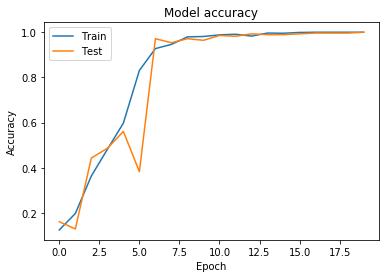

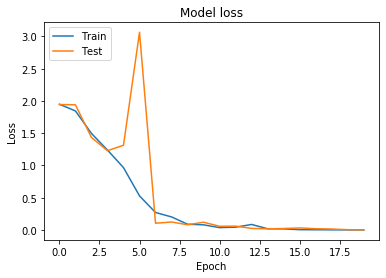

In [29]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()